<a href="https://colab.research.google.com/github/skyshine460/music_genre/blob/main/lightgbm_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix

import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [75]:
df_train = pd.read_csv("/content/drive/MyDrive/楽曲のジャンル推定チャレンジ！！（SOTA：SIGNATE Student Cup 2021春）/提供データ/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/楽曲のジャンル推定チャレンジ！！（SOTA：SIGNATE Student Cup 2021春）/提供データ/test.csv")
df_sample_sub = pd.read_csv("/content/drive/MyDrive/楽曲のジャンル推定チャレンジ！！（SOTA：SIGNATE Student Cup 2021春）/提供データ/sample_submit.csv", header=None)
df_sample_sub.columns = ["index", "genre"]
df_genre_labels = pd.read_csv("/content/drive/MyDrive/楽曲のジャンル推定チャレンジ！！（SOTA：SIGNATE Student Cup 2021春）/提供データ/genre_labels.csv")

In [76]:
def merge_train_test(df_train, df_test):
    if "genre" not in df_test.columns.tolist():
        df_test["genre"] = -100
    res = pd.concat([df_train, df_test])
    res.reset_index(inplace=True, drop=True)
    return res

def split_train_test(df):
    df_train = df[df["genre"] != -100]
    df_test = df[df["genre"] == -100]
    df_train.reset_index(inplace=True, drop=True)
    df_test.reset_index(inplace=True, drop=True)
    return df_train, df_test

df = merge_train_test(df_train, df_test)

In [77]:
# ジャンル名を表示
df["genre_name"] = df["genre"].map(dict(df_genre_labels[["labels", "genre"]].values))

# tempoを数値に変換（中央値、対数）
df["tempo"] = df["tempo"].map(lambda x: sum(map(int, x.split("-"))) / 2)
df["log_tempo"] = np.log(df["tempo"])

# regionをワンホットエンコーディング
df = pd.concat([df, pd.get_dummies(df["region"]).rename(columns={"unknown": "region_unknown"}).astype(float)], axis=1)

# 欠損値の個数をカラム化
df["num_nans"] = 0
for col in [
    "acousticness",
    "positiveness",
    "danceability",
    "energy",
    "liveness",
    "speechiness",
    "instrumentalness",
]:
    df["num_nans"] += df[col].isna()

In [78]:
# 欠損値を補間(kNN-mean)
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

numeric_columns =  [
    "acousticness",
    "positiveness",
    "danceability",
    "energy",
    "liveness",
    "speechiness",
    "instrumentalness",
]

# MinMaxScalerのインスタンスを作成
scaler = MinMaxScaler()

# スケーリングを実行
df_scaled_array = scaler.fit_transform(df[numeric_columns])

# 補間を行うためのKNNImputerを設定
imputer = KNNImputer(n_neighbors=2)

# k-NN補間を使用して欠損値を補完
df_imputed_array = imputer.fit_transform(df_scaled_array)

# 補完されたデータを元のスケールに逆変換
df_imputed_original = scaler.inverse_transform(df_imputed_array)

# 補完されたデータをDataFrameに戻す
df_imputed = pd.DataFrame(df_imputed_original, columns=numeric_columns)

# merged_dfの特定のカラムをdf_imputedで置き換える
df[numeric_columns] = df_imputed

# 欠損値の確認
print(df.isnull().sum())

index                  0
genre                  0
popularity             0
duration_ms            0
acousticness           0
positiveness           0
danceability           0
loudness               0
energy                 0
liveness               0
speechiness            0
instrumentalness       0
tempo                  0
region                 0
genre_name          4046
log_tempo              0
region_A               0
region_B               0
region_C               0
region_D               0
region_E               0
region_F               0
region_G               0
region_H               0
region_I               0
region_J               0
region_K               0
region_L               0
region_M               0
region_N               0
region_O               0
region_P               0
region_Q               0
region_R               0
region_S               0
region_T               0
region_unknown         0
num_nans               0
dtype: int64


In [79]:
# 各カラムを正規化
for col in [
    'popularity', 'duration_ms', 'acousticness',
    'positiveness', 'danceability', 'loudness', 'energy', 'liveness',
    'speechiness', 'instrumentalness', 'log_tempo', 'num_nans',
]:
    df["standardscaled_" + col] = StandardScaler().fit_transform(df[[col]])[:, 0]

In [80]:
df.columns

Index(['index', 'genre', 'popularity', 'duration_ms', 'acousticness',
       'positiveness', 'danceability', 'loudness', 'energy', 'liveness',
       'speechiness', 'instrumentalness', 'tempo', 'region', 'genre_name',
       'log_tempo', 'region_A', 'region_B', 'region_C', 'region_D', 'region_E',
       'region_F', 'region_G', 'region_H', 'region_I', 'region_J', 'region_K',
       'region_L', 'region_M', 'region_N', 'region_O', 'region_P', 'region_Q',
       'region_R', 'region_S', 'region_T', 'region_unknown', 'num_nans',
       'standardscaled_popularity', 'standardscaled_duration_ms',
       'standardscaled_acousticness', 'standardscaled_positiveness',
       'standardscaled_danceability', 'standardscaled_loudness',
       'standardscaled_energy', 'standardscaled_liveness',
       'standardscaled_speechiness', 'standardscaled_instrumentalness',
       'standardscaled_log_tempo', 'standardscaled_num_nans'],
      dtype='object')

In [81]:
def grouping_calculation(df, features_colc, group_col):
    for col in features_colc:
        # ジャンルごとの平均値と標準偏差を計算
        group_stats = df.groupby(group_col)[col].agg(['mean', 'std']).reset_index()
        group_stats.rename(columns={'mean': col+'_mean_'+group_col, 'std': col+'_std_'+group_col}, inplace=True)

        # 元のデータフレームにマージ
        df = pd.merge(df, group_stats, on=group_col, how='left')

        # 平均値との差の絶対値を計算
        df[col+'_diff'] = abs(df[col] - df[col+'_mean_'+group_col])

        # 標準化を計算
        df[col+'_z'] = (df[col] - df[col+'_mean_'+group_col]) / df[col+'_std_'+group_col]

    return df


In [82]:
features_colc = ['popularity', 'duration_ms', 'acousticness', 'positiveness', 'danceability',
                  'energy', 'liveness', 'speechiness', 'instrumentalness']

df = grouping_calculation(df, features_colc, "region")
df.head(10)

,index,genre,popularity,duration_ms,acousticness,positiveness,danceability,loudness,energy,liveness,speechiness,instrumentalness,tempo,region,genre_name,log_tempo,region_A,region_B,region_C,region_D,region_E,region_F,region_G,region_H,region_I,region_J,region_K,region_L,region_M,region_N,region_O,region_P,region_Q,region_R,region_S,region_T,region_unknown,num_nans,standardscaled_popularity,standardscaled_duration_ms,standardscaled_acousticness,standardscaled_positiveness,standardscaled_danceability,standardscaled_loudness,standardscaled_energy,standardscaled_liveness,standardscaled_speechiness,standardscaled_instrumentalness,standardscaled_log_tempo,standardscaled_num_nans,popularity_mean_region,popularity_std_region,popularity_diff,popularity_z,duration_ms_mean_region,duration_ms_std_region,duration_ms_diff,duration_ms_z,acousticness_mean_region,acousticness_std_region,acousticness_diff,acousticness_z,positiveness_mean_region,positiveness_std_region,positiveness_diff,positiveness_z,danceability_mean_region,danceability_std_region,danceability_diff,danceability_z,energy_mean_region,energy_std_region,energy_diff,energy_z,liveness_mean_region,liveness_std_region,liveness_diff,liveness_z,speechiness_mean_region,speechiness_std_region,speechiness_diff,speechiness_z,instrumentalness_mean_region,instrumentalness_std_region,instrumentalness_diff,instrumentalness_z
0,0,10,11,201094,0.112811,0.157247,0.187841,-1.884852,0.893918,0.363568,0.390108,0.888884,136.5,region_H,rock,4.916325,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,-1.866000,-0.499932,-0.955367,-1.384008,-1.961677,1.430045,1.432662,0.614684,2.233794,4.338674,0.549758,-0.049673,33.594805,16.577375,22.594805,-1.362991,241215.114286,74969.668951,40121.114286,-0.535165,0.361314,0.244860,0.248502,-1.014876,0.417410,0.222599,0.260163,-1.168754,0.464421,0.173076,0.276579,-1.598021,0.589758,0.223368,0.304160,1.361700,0.273181,0.167866,0.090387,0.538449,0.199170,0.083200,0.190938,2.294931,0.234180,0.172665,0.654704,3.791754
1,1,8,69,308493,0.101333,0.346563,0.554444,-5.546495,0.874409,0.193892,0.161497,0.123910,164.5,region_I,pop,5.102911,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.728761,0.812810,-1.003456,-0.534239,0.330991,0.525867,1.335512,-0.470802,-0.455774,-0.588491,1.269242,-0.049673,40.509218,16.328317,28.490782,1.744869,239207.812460,75697.170685,69285.187540,0.915294,0.318765,0.227062,0.217432,-0.957587,0.486123,0.214891,0.139560,-0.649447,0.508782,0.157734,0.045662,0.289487,0.621247,0.190882,0.253162,1.326272,0.273367,0.158931,0.079475,-0.500061,0.205801,0.088607,0.044305,-0.500011,0.199632,0.128815,0.075721,-0.587831
2,2,3,43,197225,0.496420,0.265391,0.457642,-9.255670,0.439933,0.217146,0.369057,0.166470,70.0,region_E,hip-hop,4.248495,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.117317,-0.547223,0.651855,-0.898592,-0.274390,-0.390048,-0.827977,-0.322035,1.986130,-0.314367,-2.025425,-0.049673,43.988914,15.418444,0.988914,-0.064138,247786.749446,65783.960840,50561.749446,-0.768603,0.348602,0.226518,0.147818,0.652563,0.447325,0.216199,0.181934,-0.841512,0.517536,0.158986,0.059894,-0.376728,0.595759,0.192668,0.155826,-0.808778,0.260587,0.150469,0.043441,-0.288703,0.200158,0.085225,0.168899,1.981808,0.199191,0.129563,0.032721,-0.252552
3,3,10,45,301092,0.165667,0.245533,0.356578,-5.088788,0.868704,0.377025,0.226677,0.175399,184.5,region_C,rock,5.217649,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.241274,0.722347,-0.733915,-0.987727,-0.906425,0.638890,1.307106,0.700769,0.311056,-0.256853,1.711681,-0.049673,39.953216,15.696689,5.046784,0.321519,257904.222222,94570.585047,43187.777778,0.456672,0.237054,0.206731,0.071388,-0.345316,0.386978,0.218795,0.141445,-0.646474,0.451074,0.152918,0.094496,-0.617948,0.685073,0.184892,0.183631,0.993184,0.267326,0.131635,0.109699,0.833359,0.193200,0.076732,0.033477,0.436282,0

In [83]:
# object型をカテゴリ型に変換する
for col in df.columns:
    if df[col].dtype == "object":  # object型の列を探す
        df[col] = df[col].astype("category")  # カテゴリ型に変換

df_train, df_test = split_train_test(df)
target = df_train["genre"]

In [84]:
df_train.dtypes

,0
index,int64
genre,int64
popularity,int64
duration_ms,int64
acousticness,float64
positiveness,float64
danceability,float64
loudness,float64
energy,float64
liveness,float64


In [85]:
N_CLASSES = 11
N_SPLITS = 15
SEED_SKF = 42
np.random.seed(42)

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED_SKF)
oof = np.zeros((len(df_train), N_CLASSES))
predictions = np.zeros((len(df_test), N_CLASSES))
df_feature_importance = pd.DataFrame()

features_numerical = [
       'popularity', 'duration_ms', 'acousticness',
       'positiveness', 'danceability', 'loudness', 'energy', 'liveness',
       'speechiness', 'instrumentalness', 'tempo',
       'log_tempo', 'region_A', 'region_B', 'region_C', 'region_D', 'region_E',
       'region_F', 'region_G', 'region_H', 'region_I', 'region_J', 'region_K',
       'region_L', 'region_M', 'region_N', 'region_O', 'region_P', 'region_Q',
       'region_R', 'region_S', 'region_T', 'region_unknown', 'num_nans',
       'standardscaled_popularity', 'standardscaled_duration_ms',
       'standardscaled_acousticness', 'standardscaled_positiveness',
       'standardscaled_danceability', 'standardscaled_loudness',
       'standardscaled_energy', 'standardscaled_liveness',
       'standardscaled_speechiness', 'standardscaled_instrumentalness',
       'standardscaled_log_tempo', 'standardscaled_num_nans',
       'popularity_mean_region', 'popularity_std_region', 'popularity_diff',
       'popularity_z', 'duration_ms_mean_region', 'duration_ms_std_region',
       'duration_ms_diff', 'duration_ms_z', 'acousticness_mean_region',
       'acousticness_std_region', 'acousticness_diff', 'acousticness_z',
       'positiveness_mean_region', 'positiveness_std_region',
       'positiveness_diff', 'positiveness_z', 'danceability_mean_region',
       'danceability_std_region', 'danceability_diff', 'danceability_z',
       'energy_mean_region', 'energy_std_region', 'energy_diff', 'energy_z',
       'liveness_mean_region', 'liveness_std_region', 'liveness_diff',
       'liveness_z', 'speechiness_mean_region', 'speechiness_std_region',
       'speechiness_diff', 'speechiness_z', 'instrumentalness_mean_region',
       'instrumentalness_std_region', 'instrumentalness_diff',
       'instrumentalness_z'
]
features_categorical = ['region']
features = features_numerical + features_categorical

class_weight パラメータ
class_weight は、分類問題でクラスの重み付けを行うためのパラメータですが、LightGBM では class_weight を直接設定する方法は通常使われません。代わりに、scale_pos_weight や is_unbalance パラメータを使ってクラスの重みを調整できます。

scale_pos_weight: 不均衡なデータセットでのクラス間の重み付けに使用します。通常は、scale_pos_weight はクラスの頻度に基づいて計算されます。
is_unbalance: 不均衡データセットを扱う場合、このパラメータを True に設定することで、クラスの重み付けが自動的に調整されます。

------------------------------ fold 0 ------------------------------
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: class_weight


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 0 F1 score: 0.51980

------------------------------ fold 1 ------------------------------
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 1 F1 score: 0.64544

------------------------------ fold 2 ------------------------------
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 2 F1 score: 0.60595

------------------------------ fold 3 ------------------------------
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 3 F1 score: 0.47351

------------------------------ fold 4 ------------------------------
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: class_weight


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 4 F1 score: 0.57787

------------------------------ fold 5 ------------------------------
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 5 F1 score: 0.56799

------------------------------ fold 6 ------------------------------
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 6 F1 score: 0.62432

------------------------------ fold 7 ------------------------------
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 7 F1 score: 0.50001

------------------------------ fold 8 ------------------------------
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 8 F1 score: 0.54252

------------------------------ fold 9 ------------------------------
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 9 F1 score: 0.55238

------------------------------ fold 10 ------------------------------
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 10 F1 score: 0.46207

------------------------------ fold 11 ------------------------------
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 11 F1 score: 0.62275

------------------------------ fold 12 ------------------------------
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 12 F1 score: 0.53026

------------------------------ fold 13 ------------------------------
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 13 F1 score: 0.54224

------------------------------ fold 14 ------------------------------
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 14 F1 score: 0.56198


Fold-wise F1 scores:
  Fold 0: 0.51980
  Fold 1: 0.64544
  Fold 2: 0.60595
  Fold 3: 0.47351
  Fold 4: 0.57787
  Fold 5: 0.56799
  Fold 6: 0.62432
  Fold 7: 0.50001
  Fold 8: 0.54252
  Fold 9: 0.55238
  Fold 10: 0.46207
  Fold 11: 0.62275
  Fold 12: 0.53026
  Fold 13: 0.54224
  Fold 14: 0.56198
CV score
  f1:  0.57054

              precision    recall  f1-score   support

           0       0.85      0.53      0.65        32
           1       0.57      0.22      0.32       205
           2       0.72      0.35      0.47       191
           3       0.74      0.70      0.72       362
           4       0.73      0.42      0.54        45
           5       0.69      0.35      0.46       126
           6       0.64      0.14      0.23        50
           7       0.62      0.53      0.57       334
           8       0.65      0.79      0.71      1305
           9       0.85      0.86  

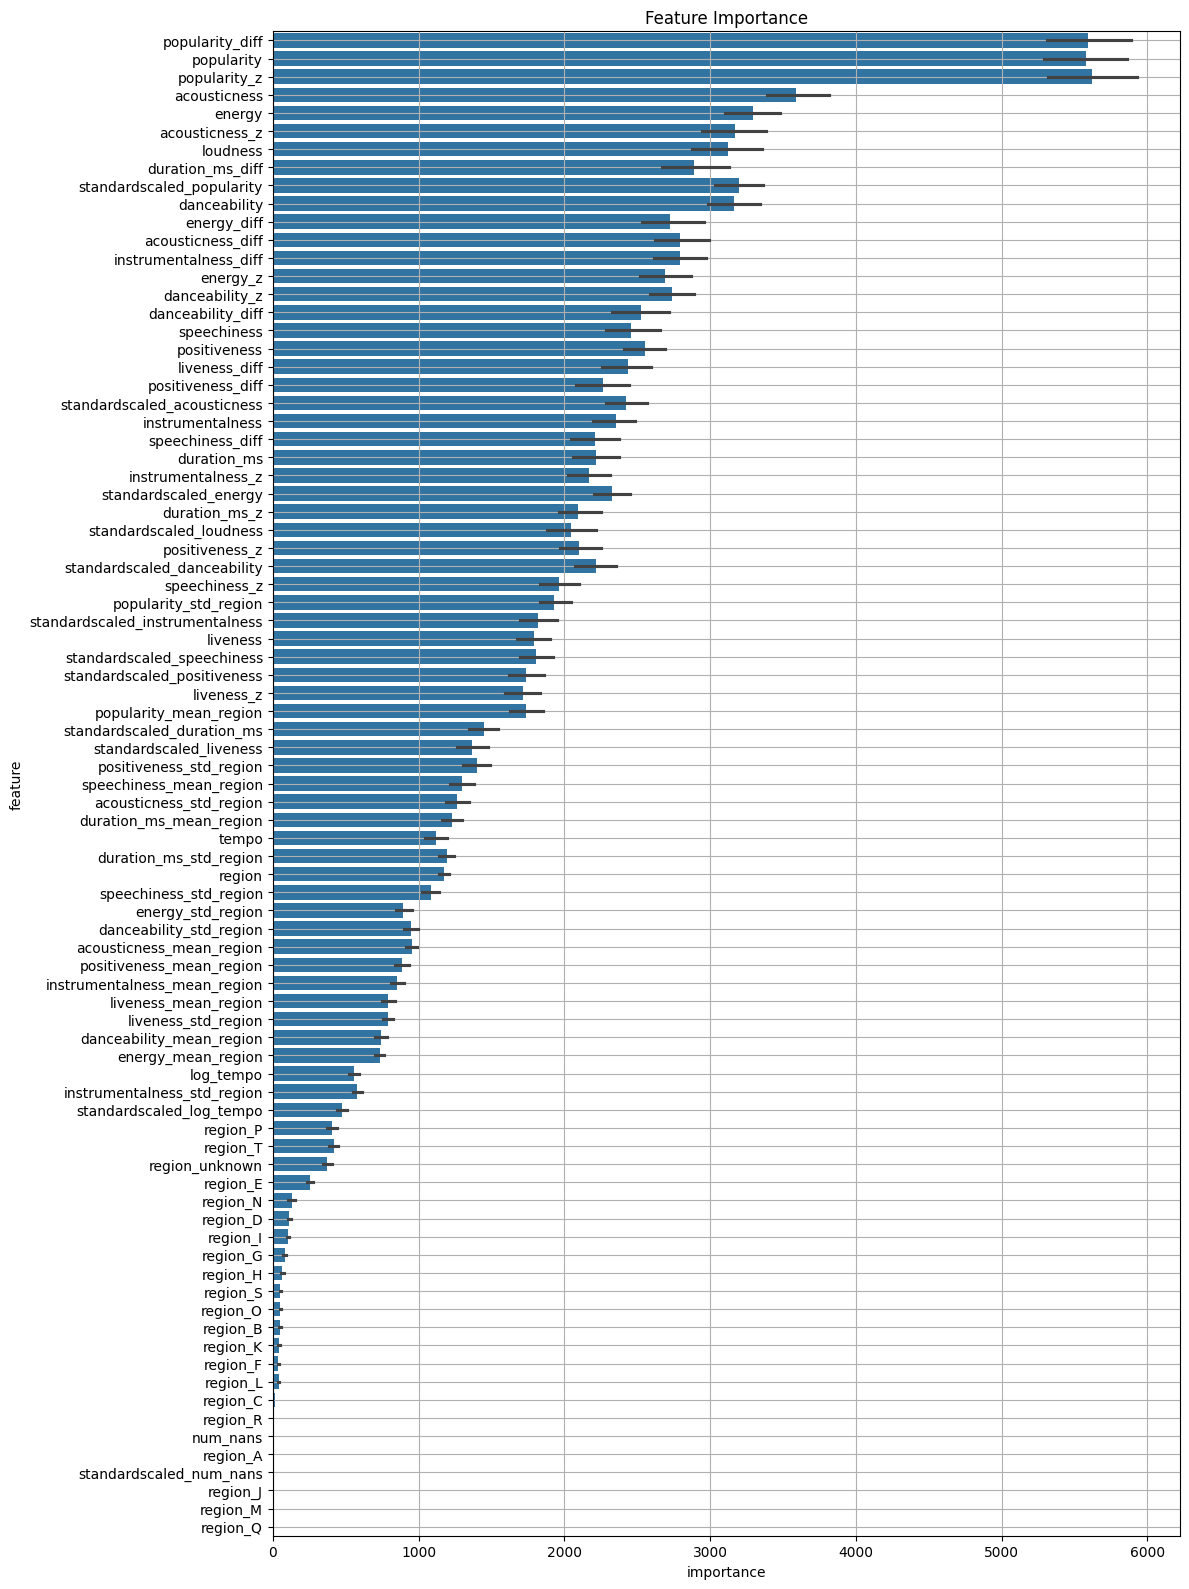

In [87]:
from sklearn.metrics import f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# 各foldごとのF1スコアを格納するリスト
fold_f1_scores = []

# foldに分けて学習と評価を行う
for fold_, (indexes_trn, indexes_val) in enumerate(skf.split(df_train.values, target.values)):
    print(f"------------------------------ fold {fold_} ------------------------------")

    # 学習データと評価データを元の学習データから抽出
    df_trn = df_train.loc[indexes_trn].reset_index(drop=True)
    target_trn = target.loc[indexes_trn].reset_index(drop=True)

    df_val = df_train.loc[indexes_val].reset_index(drop=True)
    target_val = target.loc[indexes_val].reset_index(drop=True)


    # lightGBMモデル用のデータセット
    lgb_train = lgb.Dataset(
        df_trn.loc[:, features],
        label=target_trn,
        feature_name=features,
        categorical_feature=features_categorical
    )
    lgb_valid = lgb.Dataset(
        df_val.loc[:, features],
        label=target_val,
        feature_name=features,
        categorical_feature=features_categorical
    )

    # モデルパラメータ設定
    lgb_params = {
        "objective": "multiclass",
        "learning_rate": 0.01,
        "min_data_in_leaf": 40,
        "verbosity": 0,
        "n_estimators": 10000,
        "num_leaves": 31,
        "random_state": 42,
        "n_jobs": -1,
        # "importance_type": "gain",
        "colsample_bytree": .5,
        "num_class": 11,
        "class_weight":"balanced"  # class weight: 逆ラベル頻度
    }

    # モデル学習の最大回数
    num_round = 999999999

    # モデル作成
    model = lgb.train(
        lgb_params,
        lgb_train,
        num_round,
        valid_sets=[lgb_train, lgb_valid],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50, verbose=False),
            lgb.log_evaluation(0)],
    )

    # 最適な学習回数を設定
    prediction_round = model.best_iteration

    # 最適な学習回数に基づいて予測
    oof[indexes_val] = model.predict(df_val[features], num_iteration=prediction_round)

    # 各foldのF1スコアを計算
    fold_f1 = f1_score(target_val, oof[indexes_val].argmax(1), average="macro")
    fold_f1_scores.append(fold_f1)
    print(f"Fold {fold_} F1 score: {fold_f1:.5f}")

    # feature importance
    df_fold_importance = pd.DataFrame()
    df_fold_importance["feature"] = features
    df_fold_importance["importance"] = model.feature_importance()
    df_fold_importance["fold"] = fold_
    df_feature_importance = pd.concat([df_feature_importance, df_fold_importance], axis=0)

    predictions += model.predict(df_test[features], num_iteration=prediction_round) / N_SPLITS
    print()

# 各foldのF1スコアを表示
print("\nFold-wise F1 scores:")
for i, f1 in enumerate(fold_f1_scores):
    print(f"  Fold {i}: {f1:.5f}")

# 最終的なF1スコア（全体）
score = f1_score(target, oof.argmax(1), average="macro")
print("CV score")
print(f"  f1: {score:8.5f}")
print()
print(classification_report(target, oof.argmax(1)))

# Feature importanceの可視化
plt.figure(figsize=(12, 16))
sns.barplot(x="importance", y="feature", data=df_feature_importance.sort_values(by="importance", ascending=False))
plt.title("Feature Importance")
plt.grid()
plt.tight_layout()
plt.show()


<ipython-input-88-3b046d3a59ea>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["prediction"] = predictions.argmax(1)


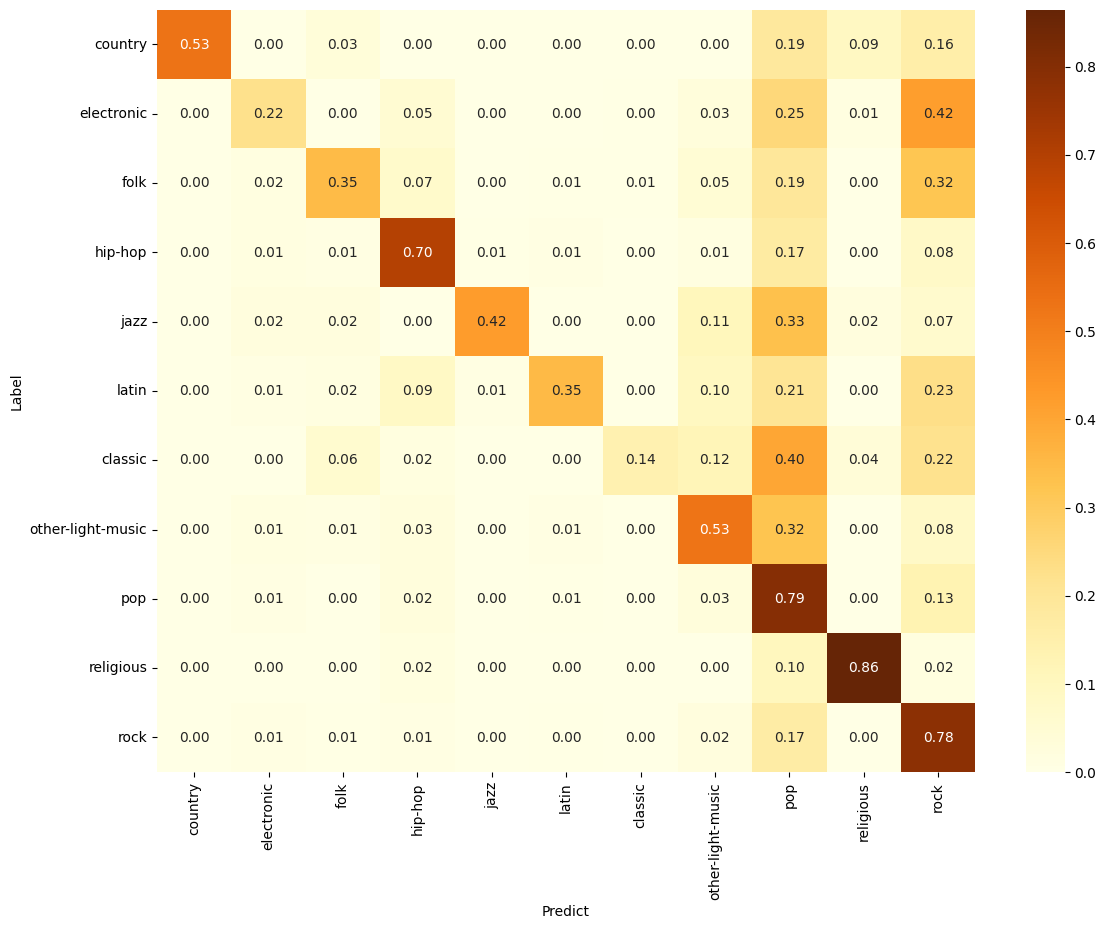

In [88]:
def visualize_confusion_matrix(y_true,
                               pred_label,
                               height=.6,
                               labels=None):  # from https://signate.jp/competitions/449/discussions/lgbm-baseline-lb06240
    conf = confusion_matrix(y_true=y_true,
                            y_pred=pred_label,
                            normalize='true')

    n_labels = len(conf)
    size = n_labels * height
    fig, ax = plt.subplots(figsize=(size * 2, size * 1.5))
    sns.heatmap(conf, cmap='YlOrBr', ax=ax, annot=True, fmt='.2f')
    ax.set_ylabel('Label')
    ax.set_xlabel('Predict')

    if labels is not None:
        ax.set_yticklabels(labels)
        ax.set_xticklabels(labels)
        ax.tick_params('y', labelrotation=0)
        ax.tick_params('x', labelrotation=90)

    return fig

df_test["prediction"] = predictions.argmax(1)
oof_label = pd.Series(np.argmax(oof, axis=1))
fig = visualize_confusion_matrix(y_true=target, pred_label=oof_label, labels=df_genre_labels["genre"])
fig.show()